In [1]:
# NO CODE

from datascience import *
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import numpy as np
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

## Towards Multiple Regression ##

This section is an extended example of applications of the methods we have derived for regression. We will start with simple regression, which we understand well, and will then indicate how some of the results can be extended when there is more than one predictor variable.

The data are from a study on the treatment of Hodgkin's disease, a type of cancer that can affect young people. The good news is that treatments for this cancer have [high success rates](https://en.wikipedia.org/wiki/Hodgkin_lymphoma#Prognosis). The bad news is that the treatments can be rather strong combinations of chemotherapy and radiation, and thus have serious side effects. A goal of the study was to identify combinations of treatments with reduced side effects.

The table `hodgkins` contains data on a random sample of patients. Each row corresponds to a patient. The columns contain the patient's height in centimeters, the amount of radiation, the amount of medication used in chemotherapy, and measurements on the health of the patient's lungs.

In [2]:
# NO CODE

hodgkins = Table.read_table('../../data/hodgkins.csv')
diffs = hodgkins.column(4) - hodgkins.column(3)
hodgkins = hodgkins.with_columns('difference', diffs)

In [3]:
hodgkins

height,rad,chemo,base,month15,difference
164,679,180,160.57,87.77,-72.8
168,311,180,98.24,67.62,-30.62
173,388,239,129.04,133.33,4.29
157,370,168,85.41,81.28,-4.13
160,468,151,67.94,79.26,11.32
170,341,96,150.51,80.97,-69.54
163,453,134,129.88,69.24,-60.64
175,529,264,87.45,56.48,-30.97
185,392,240,149.84,106.99,-42.85
178,479,216,92.24,73.43,-18.81


In [4]:
n = hodgkins.num_rows
n

22

The radiation was directed towards each patient's chest area or "mantle", to destroy cancer cells in the lymph nodes near that area. Since this could adversely affect the patients' lungs, the researchers measured the health of the patients' lungs both before and after treatment. Each patient received a score, with larger scores corresponding to more healthy lungs. 

The table records the baseline scores and also the scores 15 months after treatment. The change in score (15 month score minus baseline score) is in the final column. Notice the negative differences: 15 months after treatment, many patients' lungs weren't doing as well as before the treatment. 

Perhaps not surprisingly, patients with larger baseline scores had bigger drops in score. 

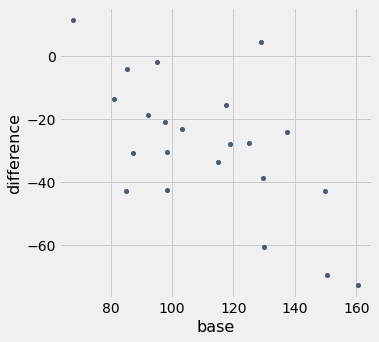

In [5]:
hodgkins.scatter('base', 'difference')

We will regress the difference on the baseline score, this time using the Python module `statsmodels` that allows us to easily perform multiple regression as well. You don't have to learn the code below (though it's not hard). Just focus on understanding an interpreting the output.

As a first step, we must import the module.

In [6]:
import statsmodels.api as sm

The `Table` method `to_df` allows us to convert the table `hodgkins` to a structure called a data frame that works more smoothly with `statsmodels`.

In [7]:
h_data = hodgkins.to_df()
h_data

,height,rad,chemo,base,month15,difference
0,164,679,180,160.57,87.77,-72.80
1,168,311,180,98.24,67.62,-30.62
2,173,388,239,129.04,133.33,4.29
3,157,370,168,85.41,81.28,-4.13
4,160,468,151,67.94,79.26,11.32
5,170,341,96,150.51,80.97,-69.54
6,163,453,134,129.88,69.24,-60.64
7,175,529,264,87.45,56.48,-30.97
8,185,392,240,149.84,106.99,-42.85
9,178,479,216,92.24,73.43,-18.81


There are several variables we could use to predict the difference. The only one we wouldn't use is the 15 month measurement, as that's precisely what we won't have for a new patient before the treatment is adminstered. 

But which of the rest should we use? One way to choose is to look at the *correlation matrix* of all the variables.

In [8]:
h_data.corr()

,height,rad,chemo,base,month15,difference
height,1.000000,-0.305206,0.576825,0.354229,0.390527,-0.043394
rad,-0.305206,1.000000,-0.003739,0.096432,0.040616,-0.073453
chemo,0.576825,-0.003739,1.000000,0.062187,0.445788,0.346310
base,0.354229,0.096432,0.062187,1.000000,0.561371,-0.630183
month15,0.390527,0.040616,0.445788,0.561371,1.000000,0.288794
difference,-0.043394,-0.073453,0.346310,-0.630183,0.288794,1.000000


Each entry in this table is the correlation between the variable specified by the row label and the variable specified by the column label. That's why all the diagonal entries are $1$.

Look at the last column (or last row). This contains the correlation between `difference` and each of the other variables. The baseline measurement has the largest correlation. To run the regression of `difference` on `base` we must first extract the columns of data that we need and then use the appropriate `statsmodels` methods.

First, we create data frames corresponding to the response and the predictor variable. The methods are not the same as for `Tables`, but you will get a general sense of what they are doing.

In [9]:
y = h_data[['difference']]  # response
x = h_data[['base']]        # predictor

# specify that the model includes an intercept
x_with_int = sm.add_constant(x) 

The name of the `OLS` method stands for Ordinary Least Squares, which is the kind of least squares that we have discussed. There are other more complicated kinds that you might encounter in more advanced classes.

There is a lot of output, some of which we will discuss and the rest of which we will leave to another class. For some reason the output includes the date and time of running the regression, right in the middle of the summary statistics.

In [10]:
simple_regression = sm.OLS(y, x_with_int).fit()
simple_regression.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             difference   R-squared:                       0.397
Model:                            OLS   Adj. R-squared:                  0.367
Method:                 Least Squares   F-statistic:                     13.17
Date:                Sun, 14 Aug 2022   Prob (F-statistic):            0.00167
Time:                        17:39:27   Log-Likelihood:                -92.947
No. Observations:                  22   AIC:                             189.9
Df Residuals:                      20   BIC:                             192.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         32.1721     17.151      1.876      0.075      -3.604      67.949
base          -0.5447      0.150     -3.630      0.002      -0.858      -0.232
==============================================================================
Omnibus:                        1.133   Durbin-Watson:                   1.774
Prob(Omnibus):                  0.568   Jarque-Bera (JB):                0.484
Skew:                           0.362   Prob(JB):                        0.785
Kurtosis:                       3.069   Cond. No.                         530.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

There are three blocks of output. We will focus only on the the middle block.

- `const` and `base` refer to the intercept and baseline measurement.
- `coef` stands for the estimated coefficients, which in our notation are $\hat{\beta_0}$ and $\hat{\beta_1}$.
- `t` is the $t$-statistic for testing whether or not the coefficient is 0. Based on our model, its degrees of freedom are $n-2 = 20$; you'll find this under `Df Residuals` in the top block.
- `P > |t|` is the total area in the two tails of the $t$ distribution with $n-2$ degrees of freedom.
- `[0.025 0.975]` are the ends of a 95% confidence interval for the parameter.

For the test of whether or not the true slope of the baseline measurement is $0$, the observed test statistic is

$$
\frac{-0.5447 - 0}{0.150} ~ = ~ -3.63
$$

The area in one tail is the chance that the $t$ distribution with $20$ degrees of freedom is less than $-3.63$. That's the cdf of the distribution evaluated at $-3.63$:

In [11]:
one_tail = stats.t.cdf(-3.63, 20)
one_tail

0.0008339581409629714

Our test is two-sided (large values of $\vert t \vert$ favor the alternative), so the $p$-value of the test is the total area of two tails, which is the displayed value $0.002$ after rounding.

In [12]:
p = 2*one_tail
p

0.0016679162819259429

To find a 95% confidence interval for the true slope, we have to replace $2$ in the expression $\hat{\beta}_1 \pm 2SE(\hat{\beta}_1)$ by the corresponding value from the $t$ distribution with 20 degrees of freedom. That's not very far from $2$:

In [13]:
t_95 = stats.t.ppf(0.975, 20)
t_95

2.0859634472658364

A 95% confidence interval for the true slope is given by $\hat{\beta}_1 \pm t_{95}SE(\hat{\beta}_1)$. The observed interval is therefore given by the calculation below, which results in the same values as in the output of `sm.OLS` above.

In [14]:
# 95% confidence interval for the true slope

-0.5447 - t_95*0.150, -0.5447 + t_95*0.150

(-0.8575945170898753, -0.23180548291012454)

### Multiple Regression ###
What if we wanted to regress `difference` on both `base` and `chemo`? The first thing to do would be to check the correlation matrix again:

In [15]:
h_data.corr()

,height,rad,chemo,base,month15,difference
height,1.000000,-0.305206,0.576825,0.354229,0.390527,-0.043394
rad,-0.305206,1.000000,-0.003739,0.096432,0.040616,-0.073453
chemo,0.576825,-0.003739,1.000000,0.062187,0.445788,0.346310
base,0.354229,0.096432,0.062187,1.000000,0.561371,-0.630183
month15,0.390527,0.040616,0.445788,0.561371,1.000000,0.288794
difference,-0.043394,-0.073453,0.346310,-0.630183,0.288794,1.000000


What you are looking for is not just that `chemo` is the next most highly correlated with `difference` after `base`. More importantly, you are looking to see how strongly the two predictor variables `base` and `chemo` are linearly related *to each other*. That is, you are trying to figure out whether the two variables pick up genuinely different dimensions of the data.

The correlation matrix shows that the correlation between `base` and `chemo` is only about $0.06$. The two predictors are not close to being linear functions of each other. So let's run the regression.

The code is exactly the same as before, except that we have included a second predictor variable.

In [16]:
y = h_data[['difference']]      # response
x2 = h_data[['base', 'chemo']]  # predictors

# specify that the model includes an intercept
x2_with_int = sm.add_constant(x2) 

multiple_regression = sm.OLS(y, x2_with_int).fit()
multiple_regression.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             difference   R-squared:                       0.546
Model:                            OLS   Adj. R-squared:                  0.499
Method:                 Least Squares   F-statistic:                     11.44
Date:                Sun, 14 Aug 2022   Prob (F-statistic):           0.000548
Time:                        17:39:27   Log-Likelihood:                -89.820
No. Observations:                  22   AIC:                             185.6
Df Residuals:                      19   BIC:                             188.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.9992     20.227     -0.049      0.961     -43.335      41.336
base          -0.5655      0.134     -4.226      0.000      -0.846      -0.285
chemo          0.1898      0.076      2.500      0.022       0.031       0.349
==============================================================================
Omnibus:                        0.853   Durbin-Watson:                   1.781
Prob(Omnibus):                  0.653   Jarque-Bera (JB):                0.368
Skew:                           0.317   Prob(JB):                        0.832
Kurtosis:                       2.987   Cond. No.                     1.36e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.36e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Ignore the scary warning above. There isn't strong multicollinearity (predictor variables being highly correlated with each other) nor other serious issues.

Just focus on the middle block of the output. It's just like the middle block of the simple regression output, with one more line corresponding to `chemo`.

All of the values in the block are interpreted in the same way as before. The only change is in the degrees of freedom: because you are estimating one more parameter, the degrees of freedom have dropped by $1$, and are thus $19$ instead of $20$.

For example, the 95% confidence interval for the slope of `chemo` is calculated as follows.

In [17]:
t_95_df19 = stats.t.ppf(0.975, 19)

0.1898 - t_95_df19*0.076, 0.1898 + t_95_df19*0.076

(0.03073017186497201, 0.348869828135028)

Finally, take a look at the value of `R-squared` in the very top line. It is $0.546$ compared to $0.397$ for the simple regression. It's a math fact that the more predictor variables you use, the higher the `R-squared` value will be. This tempts people into using lots of predictors, whether or not the resulting model is comprehensible.

With an "everything as well as the kitchen sink" approach to selecting predictor variables, a researcher might be inclined to use all the possible predictors.

In [18]:
y = h_data[['difference']]      # response
x3 = h_data[['base', 'chemo', 'rad', 'height']]  # predictors

# specify that the model includes an intercept
x3_with_int = sm.add_constant(x3) 

bad_regression = sm.OLS(y, x3_with_int).fit()
bad_regression.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             difference   R-squared:                       0.550
Model:                            OLS   Adj. R-squared:                  0.444
Method:                 Least Squares   F-statistic:                     5.185
Date:                Sun, 14 Aug 2022   Prob (F-statistic):            0.00645
Time:                        17:39:27   Log-Likelihood:                -89.741
No. Observations:                  22   AIC:                             189.5
Df Residuals:                      17   BIC:                             194.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         33.5226    101.061      0.332      0.744    -179.698     246.743
base          -0.5393      0.160     -3.378      0.004      -0.876      -0.202
chemo          0.2124      0.103      2.053      0.056      -0.006       0.431
rad           -0.0062      0.031     -0.203      0.841      -0.071       0.059
height        -0.2274      0.658     -0.346      0.734      -1.615       1.160
==============================================================================
Omnibus:                        0.589   Durbin-Watson:                   1.812
Prob(Omnibus):                  0.745   Jarque-Bera (JB):                0.321
Skew:                           0.286   Prob(JB):                        0.852
Kurtosis:                       2.851   Cond. No.                     1.46e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.46e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

This is not a good idea. We end up with a far more complicated model for no appreciable gain in `R-squared`. The "adjusted $R^2$" penalizes us for using more predictor variables: notice that the value of `Adj. R-squared` is smaller for the regression with all the predictors than for the regression with just `base` and `chemo`.

Curious about how to select predictors, or about what makes a good regression? Then take some more statistics classes! This one is complete.